In [7]:
import os
import numpy as np
import librosa
import random

# DATA PROCESSING
DATASET_PATH = "/home/gmallet/datasets/gtzan"
ROI_PATH = DATASET_PATH + "/genres_original/"

TIME_SERIES_LENGTH = 128
HOP_LENGTH = 512
CATEGORIES = os.listdir(ROI_PATH)

# AUDIO SAMPLING RATE
sr = 22050
SONG_DURATION = 29
# TOTAL NB SAMPLE OF EACH SONG
TOTAL_SAMPLES = SONG_DURATION * sr
# NB SLICE PER SONG
NB_SLICES = 10
# HOW MANY SAMPLE IS NEEDED TO MAKE A SLICE
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NB_SLICES)

def get_files(root_path, extension):
    files_paths = []
    for root, _, files in os.walk(root_path, topdown=True):
        files_paths += [os.path.join(root, file) for file in files if file.endswith(extension)]
    return files_paths

# USE ALL POSSIBLE SAMPLE PER SONG
def extract_audio_features(files_paths):
    labels = []
    features = []
    for i, file_path in enumerate(files_paths):
        song, sr = librosa.load(file_path, duration=SONG_DURATION)
        genre = file_path.split("/")[-2]
        index = CATEGORIES.index(genre)
        for s in range(NB_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            labels.append(index)
            features.append(mfcc.tolist())
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, len(files_paths)), end=''
        )
    print()
    return (np.array(features), np.array(labels))


# USE ONLY ONE SAMPLE PER SONG, AND STILL MFCC ON THE WHOLE SONG SO REALLY BAD
def bad_extract_audio_features(files_paths):
    nb_files = len(files_paths)
    
    features = np.zeros(
        (nb_files, TIME_SERIES_LENGTH, 13), dtype=np.float64
    )
    
    
    labels = np.zeros(
        (nb_files, 1), dtype=np.int32
     )
    
    for i, file in enumerate(files_paths):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=HOP_LENGTH, n_mfcc=13
        )
            
        genre = file.split("/")[-2]
        index = CATEGORIES.index(genre)
        
        labels[i][0] = index 
        features[i, :] = mfcc.T[0:TIME_SERIES_LENGTH, :]
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, nb_files), end=''
        )
    print()
    return (features, labels)



def load_data(files_path):
    files_paths = get_files(files_path, "wav")
    random.shuffle(files_paths)
    a, b = int(len(files_paths) * 0.8), int(len(files_paths) * 0.9)
    train_fp, val_fp, test_fp = files_paths[:a], files_paths[a:b], files_paths[b:]

    return {
        "train": extract_audio_features(train_fp),
        "validate": extract_audio_features(val_fp),
        "test": extract_audio_features(test_fp),
    }

dataset = load_data(ROI_PATH)

Extracted features audio track 799 of 799.
Extracted features audio track 100 of 100.
Extracted features audio track 100 of 100.


In [11]:
dataset["train"][0].shape

(7990, 125, 13)

In [12]:
# MODEL
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy

# USING LSTM
def get_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
    model.add(Dense(units=output_size, activation="softmax"))

    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

2022-03-30 22:47:15.882634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 22:47:15.882655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
# TRAINING
batch_size = 30
num_epochs = 20

def train(dataset):
    input_shape = (dataset["test"][0].shape[1], dataset["test"][0].shape[2])
    model = get_model(input_shape, 10)
    return model, model.fit(
        dataset["train"][0],
        dataset["train"][1],
        validation_data=dataset["validate"],
        batch_size=batch_size,
        epochs=num_epochs,
        shuffle=True
    )

In [14]:
# VISUALIZATION
import matplotlib.pyplot as plt

def show_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [15]:
model, history = train(dataset)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     


2022-03-30 22:47:26.091308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-30 22:47:26.091332: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 22:47:26.091347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (station): /proc/driver/nvidia/version does not exist
2022-03-30 22:47:26.091598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 93,642
Trainable params: 93,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/home/gmallet/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


267/267 [==============================] - 56s 193ms/step - loss: 1.7131 - accuracy: 0.3974 - val_loss: 1.7429 - val_accuracy: 0.3480
Epoch 2/20
267/267 [==============================] - 51s 192ms/step - loss: 1.4858 - accuracy: 0.4603 - val_loss: 1.6079 - val_accuracy: 0.4470
Epoch 3/20
267/267 [==============================] - 51s 191ms/step - loss: 1.3893 - accuracy: 0.4981 - val_loss: 1.5198 - val_accuracy: 0.4260
Epoch 4/20
267/267 [==============================] - 51s 192ms/step - loss: 1.2941 - accuracy: 0.5473 - val_loss: 1.4133 - val_accuracy: 0.4710
Epoch 5/20
267/267 [==============================] - 51s 190ms/step - loss: 1.1957 - accuracy: 0.5802 - val_loss: 1.3866 - val_accuracy: 0.5000
Epoch 6/20
267/267 [==============================] - 51s 191ms/step - loss: 1.1662 - accuracy: 0.5902 - val_loss: 1.3561 - val_accuracy: 0.4930
Epoch 7/20
267/267 [==============================] - 51s 192ms/step - loss: 1.0509 - accuracy: 0.6312 - val_loss: 1.3414 - val_accuracy: 0.5

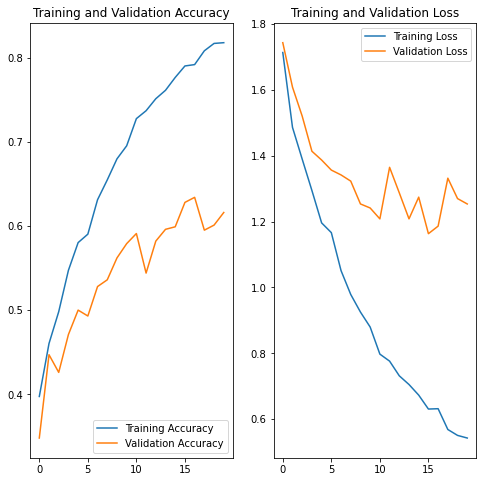

In [16]:
show_history(history)
# WE CAN SEE HERE THAT OUR MODEL IS NOW (THAT WE EXTRACT CORRECTLY DATA FROM AUDIO) LEARNING CORRECTLY, EVEN
# THO THE MODEL TENDS TO OVERFIT QUICKLY, IT STILL DON'T, SO COULD TRY ADDING MORE EPOCH, SHOULD PROBABLY MAKE
# BATCH SIZE A LITTLE LESS SO IT TRAIN FASTER THO, THIS ONE TRAINING TOOK ALMOST 10MIN

In [17]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=batch_size, verbose=1
)

34/34 [==============================] - 1s 25ms/step - loss: 1.1886 - accuracy: 0.6540


[1.188636302947998, 0.6539999842643738]